In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline


from functools import partial
from tqdm import tqdm
import pickle
from pathlib import Path
import tensorboard
import numpy as np
import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.metrics import tensorboard

from haiku._src.nets.resnet import ResNet18
import optax
import haiku as hk

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfd = tfp.distributions

from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset
from sbi_lens.normflow.models import AffineSigmoidCoupling, ConditionalRealNVP, AffineCoupling

from sbi_lens.gen_dataset.utils import augmentation_noise, augmentation_flip
from sbi_lens.config import config_lsst_y_10


import cmasher as cmr
from chainconsumer import ChainConsumer

'unset XLA_FLAGS'

Populating the interactive namespace from numpy and matplotlib


/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
2023-06-23 15:50:45.381778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/python-3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeD

'unset XLA_FLAGS'

#### Deal with Warnings 

In [3]:
import logging


import tensorflow_probability as tfp; tfp = tfp.substrates.jax


tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())


tfp.distributions.TransformedDistribution(tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity())

<tfp.distributions.TransformedDistribution 'identityNormal' batch_shape=[] event_shape=[] dtype=float32>

### Load data

In [4]:
##################################################
data = np.load("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/VMIM-vs-MSE-/notebook/LOADED&COMPRESSED_vmim_year_10_without_noise_score_density.npz", allow_pickle=True)
sample=data['arr_0'].reshape(1)[0]

## Create NF for SBI

In [5]:
bijector_layers = [128] * 2

bijector= partial(
  AffineCoupling,
  layers=bijector_layers,
  activation=jax.nn.silu
)

NF= partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector
)

class Flow_nd(hk.Module):
    def __call__(self, y):
        nvp = NF(6)(y)
        return nvp



In [6]:
nvp_nd = hk.without_apply_rng(
  hk.transform(
    lambda theta, y : Flow_nd()(y).log_prob(theta).squeeze()
  )
 )
params_nd = nvp_nd.init(jax.random.PRNGKey(42), 0.5*jnp.ones([1,6]), 0.5*jnp.ones([1,6]))

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


### Define loss function and update function

In [7]:
def loss_nll(params, theta, y_s):

    log_prob = nvp_nd.apply(
        params,
        theta,
        y_s
    )
    return -jnp.mean(log_prob), _

@jax.jit    
def update(
    params,
    opt_state,
    theta,
    y_s
  ):

    (loss, _), grads = jax.value_and_grad(
      loss_nll,
      has_aux=True
    )(params, theta, y_s)

    updates, new_opt_state = optimizer.update(
      grads,
      opt_state
    )

    new_params = optax.apply_updates(
      params,
      updates
    )

    return loss, new_params, new_opt_state

In [8]:

total_steps = 10_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.2):0.5,
                           int(total_steps*0.4):0.5,
                           int(total_steps*0.6):0.5,
                           int(total_steps*0.8):0.5}
)

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_nd = optimizer.init(params_nd)


## Training

In [9]:

batch_loss=[]
for i in tqdm(range(total_steps)):
    l, params_nd, opt_state_nd,=update(
        params = params_nd, 
        opt_state=opt_state_nd,
        ##################
        theta = sample['theta'][i].reshape(1,6), 
        y_s=sample['theta_s'][i].reshape(1,6),
    )

    if jnp.isnan(l):
      print('NaN Loss')
      break
    batch_loss.append(l)

  0%|          | 0/10000 [00:00<?, ?it/s]/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
100%|██████████| 10000/10000 [00:29<00:00, 340.72it/s]


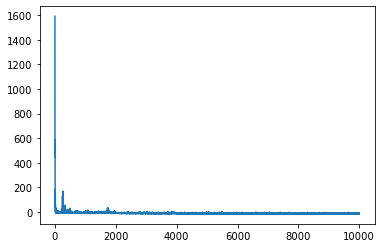

In [10]:

plt.plot(batch_loss)

In [11]:
with open("/gpfsdswork/projects/rech/ykz/ulm75uc/VMIM-vs-MSE-/data/sample_nd_vmim.pkl", 'rb') as g:
    sample_nd_vmim = pickle.load(g) 
y= np.load("/linkhome/rech/genmfd01/ulm75uc/VMIM-vs-MSE-/notebook/COMPRESSED_fiducial_vmim_year_10_without_noise_score_density.npy")

In [12]:

nvp_sample_nd = hk.transform(
    lambda x : Flow_nd()(x).sample(1000000, seed=hk.next_rng_key())
)

tfd= tfp.distributions
tfb = tfp.bijectors
sample_nd = nvp_sample_nd.apply(
    params_nd, 
    rng = jax.random.PRNGKey(43), 
    x = y*jnp.ones([1000000,6])
)

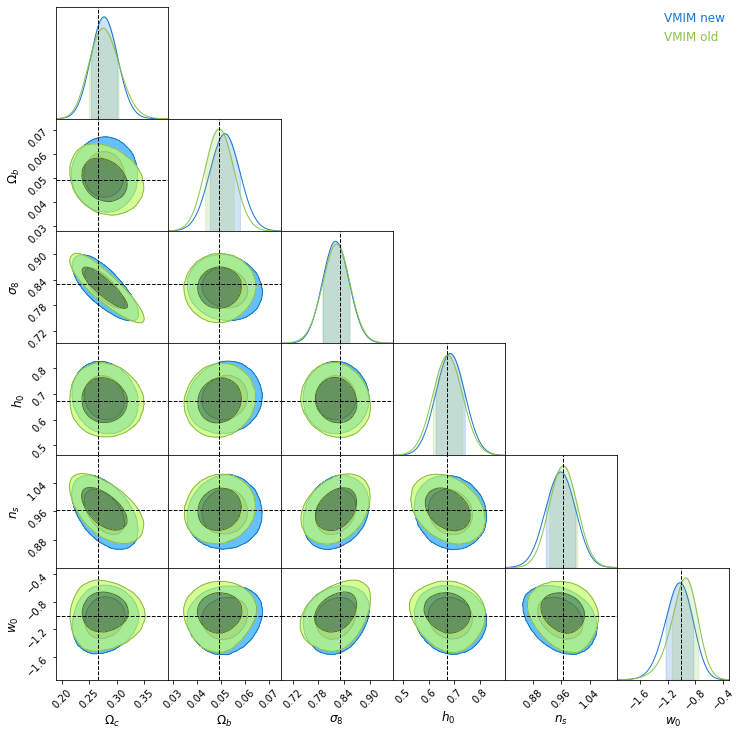

In [13]:
name_parameters= ['$\Omega_c$', '$\Omega_b$', '$\sigma_8$', '$h_0$', '$n_s$', '$w_0$']

col = cmr.eclipse([0.,0,0.55,0.85]) 
fid_params=np.array([0.2664, 0.0492, 0.831,0.6727,0.9645, -1.0])

c = ChainConsumer()

c.add_chain([sample_nd[:,i] for i in range(6)], parameters= name_parameters, name = 'VMIM new')
c.add_chain([sample_nd_vmim[:,i] for i in range(6)], parameters= name_parameters, name = 'VMIM old')
fig = c.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())


In [ ]:

# with open("params_nd_{}.pkl".format(Train), "wb") as fp:
#   pickle.dump(params_nd, fp)

# with open("opt_state_nd_{}.pkl".format(Train), "wb") as fp:
#   pickle.dump(opt_state_nd, fp)

# with open("sample_nd_{}.pkl".format(Train), "wb") as fp:
#   pickle.dump(sample_nd, fp)
